In [1]:
import pandas as pd
import numpy as n
import pickle
import re
from pathlib import Path
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

"""
root = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
while root.parent != root:
    if ((root / ".git").exists() and 
        (root / "README.txt").exists() and 
        (root / "results.ipynb").exists()): break
    root = root.parent
if str(root) not in sys.path: sys.path.insert(0, str(root))

print("Root folder at: ", root)"""

# Detect root starting from this file or from notebook’s cwd
try:
    start_path = Path(__file__).resolve()
except NameError:
    start_path = Path.cwd()

root = start_path
while root != root.parent:
    # Check for any known project markers
    if any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb", "README.txt"]):
        break
    root = root.parent

# Sanity check — fallback if nothing found
if not any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb", "README.txt"]):
    print("⚠️ Project root not found — defaulting to current working directory")
    root = Path.cwd()

print(f"✅ Root folder detected at: {root}")

# Add project root to sys.path if not already
if str(root) not in sys.path:
    sys.path.insert(0, str(root))

from src.utils.paths import *
from src.utils.general_utils import *

stored_dataprep_pkl_path = root / STORED_DATAPREP_PKL_PATH
with open(stored_dataprep_pkl_path, "rb") as f:
    data = pickle.load(f)

✅ Root folder detected at: /Users/todorovkatia/Documents/EPFL/MA3/ADA/Projet/ada-2025-project-adacore42


In [2]:
from textblob import TextBlob
import nltk
from collections import Counter
import re
import numpy as np
from textblob import download_corpora
#run this in the terminal : python -m textblob.download_corpora 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/todorovkatia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/todorovkatia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/todorovkatia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/todorovkatia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 1. Data preparation


In [3]:
dataA = data['dataA']

dfs_with_id = [
    df.assign(source_id=i)   # ajoute une colonne avec l’indice du DF
    for i, df in enumerate(dataA)
]

# Concaténation des DataFrames
dataAm2 = pd.concat(dfs_with_id, ignore_index=True)
dataAm2.sort_values(by='funny_score_scaled', ascending=False, inplace=True)
print(dataAm2.shape)
dataAm2_2=dataAm2.drop_duplicates()
print(dataAm2_2.shape)

(2292678, 11)
(2292354, 11)


In [4]:
from tqdm import tqdm
results_blob = []
#subset_test_rf =dataAm2_2.loc[30000:100000,] 
#ubset_test_rf = subset_test_rf.reset_index().rename(columns={"index": "caption_id"})
dataAm2_2 = dataAm2_2.reset_index().rename(columns={"index": "caption_id"})
for i, cap in tqdm(zip(dataAm2_2['caption_id'], dataAm2_2['caption']), total=len(dataAm2_2)):
    blob = TextBlob(cap)
    results_blob.append({
        'caption_id': i,
        'polarity': blob.sentiment.polarity,
        'subjectivity': blob.sentiment.subjectivity,
        'num_words': len(blob.words),
        'num_punct': len(re.findall(r'[^\w\s]', cap)),
        'num_repeats': len(re.findall(r'\b(\w+)\s+\1\b', cap.lower()))
    })

df_blob = pd.DataFrame(results_blob)

dataAm_rf = dataAm2_2.merge(df_blob, on="caption_id", how="inner")

100%|██████████| 2292354/2292354 [03:23<00:00, 11239.98it/s]


In [5]:
dataAm_rf= dataAm_rf[dataAm_rf["num_words"]<80]

In [6]:
dataAm_rf

,caption_id,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score,funny_score_scaled,funny_group,source_id,polarity,subjectivity,num_words,num_punct,num_repeats
0,862178,Lunch is on me.,2.518294,0.004085,25200,2183,7784,15232,36.70,100.000000,funny,153,0.00000,0.000000,4,1,0
1,452628,Mission accomplished. We will report that this...,2.998918,0.001083,924,0,1,923,34.13,95.262673,funny,88,0.28750,0.500000,14,3,0
2,1041265,Looks like you're already familiar with the si...,2.387410,0.005740,14726,1941,5211,7574,30.64,88.829493,funny,188,0.37500,0.500000,10,2,0
3,1048528,I just want to make sure 'mousse' isn't a typo.,2.354409,0.006038,14266,2078,5048,7126,29.57,86.857143,funny,189,0.50000,0.888889,11,4,0
4,934245,Is the salmon fresh?,2.338348,0.005993,14423,2164,5232,7027,29.14,86.064516,funny,168,0.30000,0.500000,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2292349,418100,They want to know if they can work remotely du...,1.000000,0.000158,6313,6313,0,0,-17.50,0.092166,not_funny,80,-0.10000,0.200000,12,0,0
2292350,418101,"Ever so subtly, Ed began to push his right win...",1.000000,0.000157,6377,6377,0,0,-17.52,0.055300,not_funny,80,-0.02381,0.517857,11,2,0
2292351,418102,I'm pretty sure I said 'hackers'.,1.000000,0.000157,6366,6366,0,0,-17.52,0.055300,not_funny,80,0.37500,0.944444,7,4,0
2292352,418103,I am concerned that this project could go sout...,1.000000,0.000157,6359,6359,0,0,-17.52,0.055300,not_funny,80,0.20000,0.600000,11,1,0


## 2. Plot exploration

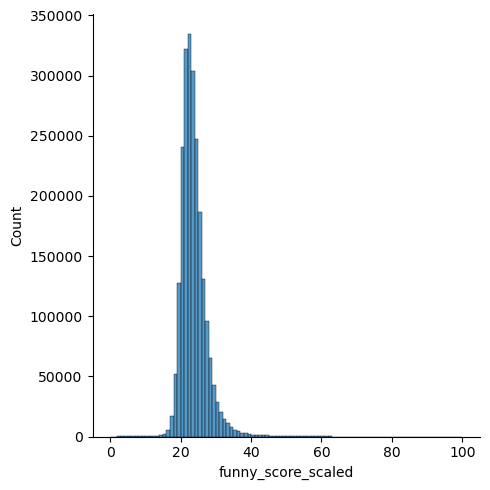

In [39]:
sns.displot(dataAm_rf, x="funny_score_scaled", bins=100)

<Axes: xlabel='funny_group', ylabel='num_words'>

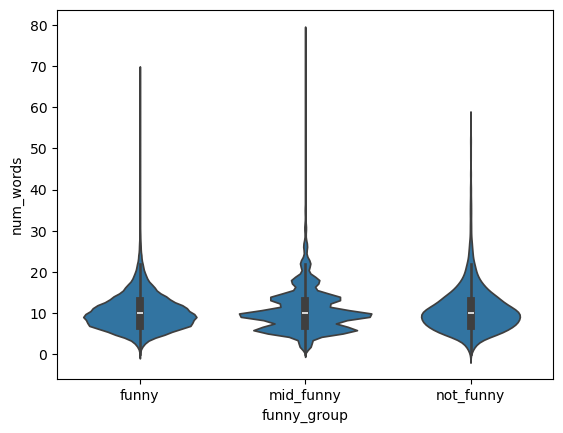

In [8]:
sns.violinplot(x='funny_group', y='num_words', data=dataAm_rf)


## 2.2 Data exploration

In [12]:
dataAm_rf.columns

Index(['caption_id', 'caption', 'mean', 'precision', 'votes', 'not_funny',
       'somewhat_funny', 'funny', 'funny_score', 'funny_score_scaled',
       'funny_group', 'source_id', 'polarity', 'subjectivity', 'num_words',
       'num_punct', 'num_repeats'],
      dtype='object')

In [ ]:
dataAm_rf.groupby('funny_group').describe()

caption_id                                                    \
                 count          mean            std       min        25%   
funny_group                                                                
funny          78775.0  1.100331e+06  641069.860817       0.0  529347.50   
mid_funny    2207081.0  1.149784e+06  662487.511484      40.0  577970.00   
not_funny       6452.0  5.702293e+05  315565.042933  103218.0  417571.75   

                                                    mean            ...  \
                   50%         75%        max      count      mean  ...   
funny_group                                                         ...   
funny        1235143.0  1606227.50  2287821.0    78775.0  1.573203  ...   
mid_funny    1146884.0  1727243.00  2292676.0  2207081.0  1.200693  ...   
not_funny     458036.5   667102.25  2292677.0     6452.0  1.014100  ...   

            num_punct        num_repeats                                     \
                  75%    max       count      mean       std  min  25%  50%   
funny_group                                                                   
funny             3.0   35.0     78775.0  0.002031  0.051592  0.0  0.0  0.0   
mid_funny         3.0  235.0   2207081.0  0.004129  0.081768  0.0  0.0  0.0   
not_funny         3.0   30.0      6452.0  0.006200  0.089567  0.0  0.0  0.0   

                        
             75%   max  
funny_group             
funny        0.0   6.0  
mid_funny    0.0  25.0  
not_funny    0.0   4.0  

[3 rows x 120 columns]

In [13]:
from scipy.stats import anderson

result = anderson(dataAm_rf["funny_score_scaled"], dist='norm')
print(result)


AndersonResult(statistic=np.float64(50595.25888574589), critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(23.740472574965178), scale=np.float64(3.7631580153665776))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


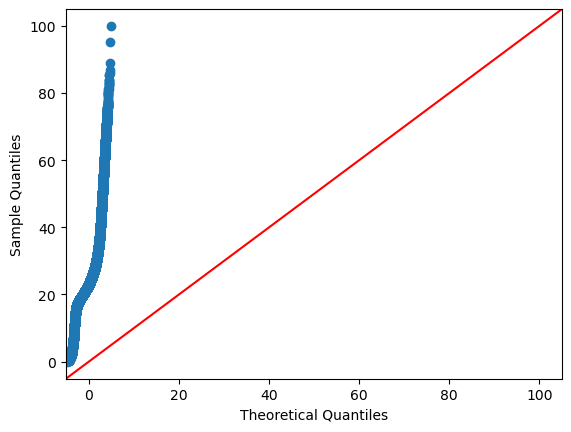

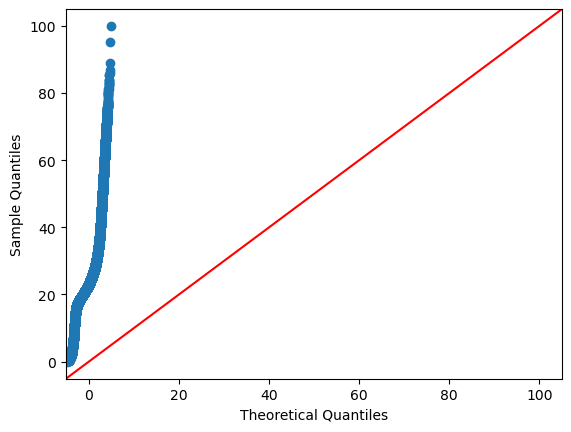

In [16]:
import statsmodels.api as sm
sm.qqplot(dataAm_rf["funny_score_scaled"], line='45')



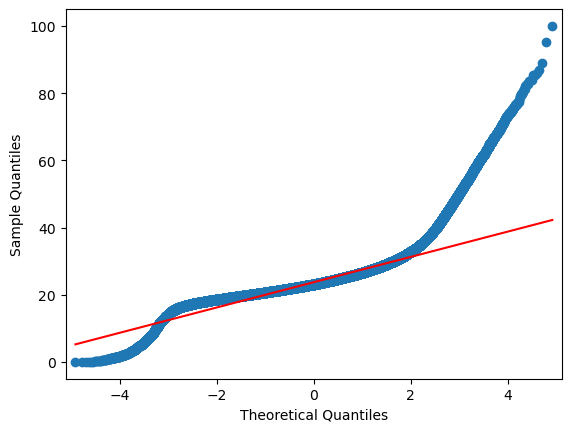

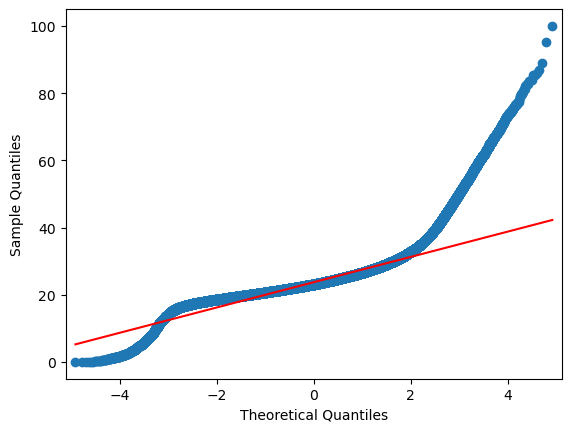

In [18]:
from scipy.stats import zscore
sm.qqplot(dataAm_rf["funny_score_scaled"], line='s')



## 3. statistical test

In [ ]:
"""results_blob = []
#subset_test_rf =dataAm2.loc[30000:100000,] 
for cap in dataAm2['caption']:
    blob = TextBlob(cap)
    results_blob.append({
        'caption': cap,
        #'tags': blob.tags,
        'words': blob.words,
        'num_words' : len(blob.words),
        'adjectives': [w for w, pos in blob.tags if pos.startswith("JJ")],
        'proper_nouns': [w for w, pos in blob.tags if pos == "NNP"],
        'num_proper_nouns' : len([w for w, pos in blob.tags if pos == "NNP"]),
        'num_verbs' : len([w for w, pos in blob.tags if pos.startswith("VB")]),
        'polarity': blob.sentiment.polarity, #sentiment entre -1 (négatif) et +1 (positif).
        'subjectivity': blob.sentiment.subjectivity, #Valeur entre 0 (objectif) et 1 (subjectif).
        'num_punct' : len(re.findall(r'[^\w\s]', cap)),
        'num_repeats' : len( re.findall(r'\b(\w+)\s+\1\b', cap.lower()))
        #'sentences': [str(s) for s in blob.sentences],
        #'nouns': blob.noun_phrases,
        #'verbs': [w.lower() for w, pos in blob.tags if pos.startswith("VB")],
        #'adverbs': [w for w, pos in blob.tags if pos.startswith("RB")],
        #'lemmas': [w.lemmatize() for w in blob.words], # pour comparer mot meme si pluriel
        #'word_counts': blob.word_counts,
        #'ngrams_2': blob.ngrams(2) # analyse mot ensemble
    })

# Convertir en DataFrame pour analyses
df_blob = pd.DataFrame(results_blob)

dataAm_rf = dataAm2.merge(df_blob, on="caption", how="inner")
dataAm_rf.to_csv("/Users/todorovkatia/Documents/EPFL/MA3/ADA/Projet/code_perso/dataAm_rf.csv", index=False)"""

In [60]:
dataAm_rf = pd.read_csv("/Users/todorovkatia/Documents/EPFL/MA3/ADA/Projet/code_perso/dataAm_rf.csv") # created in Random_forest file

KeyboardInterrupt: 

In [40]:
dataAm2.funny_group.value_counts()

funny_group
mid_funny    2207445
funny          78781
not_funny       6452
Name: count, dtype: int64

In [ ]:
list_features = ['num_words', 'num_proper_nouns', 'num_verbs', 'polarity', 'subjectivity', 'num_punct', 'num_repeats']
dataAm_rf.groupby('funny_group')[list_features].mean()
dataAm_rf.groupby('funny_group')[list_features].describe()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

for feat in list_features:
    plt.figure(figsize=(8,5))
    sns.boxplot(data=dataAm_rf, x='funny_group', y=feat)
    plt.title(f"Distribution of {feat} by Funny Group")
    plt.xlabel("Funny Group")
    plt.ylabel(feat)
    plt.grid(axis="y", alpha=0.3)
    plt.show()
